# Faire un métamodèle de krigeage


### Définition du modèle

In [1]:
import openturns as ot

Etape A : définition du modèle. Nous commençons par définir une fonction symbolique qui évalue la sortie y en fonction des entrées E, F, L et I.

In [2]:
model = ot.SymbolicFunction(["E", "F", "L", "I"], ["F * L ^ 3 / (3 * E * I)"])

Etape B : définition des distributions du vecteur aléatoire en entrée. Nous définissons ensuite les lois de distribution des variables aléatoires E, F, L et I.

In [3]:
# Young's modulus E: beta distribution
E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
E.setDescription("E")
# Load F: lognormal distribution
F = ot.LogNormal()  # in N
F.setParameter(ot.LogNormalMuSigma()([3e4, 9e3, 0.0]))
F.setDescription("F")
# Length L: uniform distribution
L = ot.Uniform(2.5, 2.6)  # in m
L.setDescription("L")
# Moment of inertia I: beta distribution
I = ot.Beta(2.5, 1.5, 310.0, 450.0)
I.setDescription("I")

Puis on définit la dépendance entre les variables d'entrée en créant une copule Gaussienne avec la classe `NormalCopula`.

In [4]:
dim = 4  # number of inputs
R = ot.CorrelationMatrix(dim)
R[2, 3] = -0.2
myCopula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(R))
myDistribution = ot.ComposedDistribution([E, F, L, I], myCopula)

### Définition d'un plan d'expériences

Nous considérons un plan d'expériences de type Monte-Carlo simple. Pour cela, on génère un échantillon des entrées grâce à la méthode `getSample`. Puis nous évaluons la sortie en appelant la fonction `model`.

In [5]:
sampleSize_train = 20
X_train = myDistribution.getSample(sampleSize_train)
Y_train = model(X_train)

Observons la distribution des déviations verticales Y sur la base d'apprentissage. On observe que les déviations plus grandes sont moins fréquentes. 

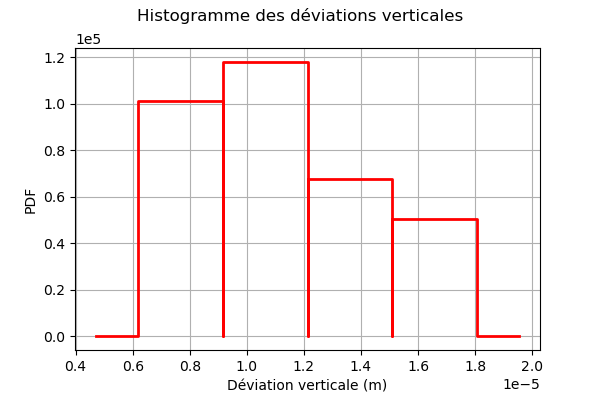

In [6]:
histo = ot.HistogramFactory().build(Y_train).drawPDF()
histo.setXTitle("Déviation verticale (m)")
histo.setTitle("Histogramme des déviations verticales")
histo.setLegends([""])
histo

### Création du méta-modèle

Pour créer le krigeage, on choisit une tendance constante avec la classe `ConstantBasisFactory`. Puis on utilise un modèle de covariance de type exponentielle carrée. Enfin, on utilise la classe `KrigingAlgorithm` pour créer le krigeage en utilisant la base d'apprentissage, le modèle de covariance et la tendance.

In [7]:
dimension = myDistribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.0] * dimension, [1.0])
covarianceModel.setScale(X_train.getMax())
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
scaleOptimizationBounds = ot.Interval(X_train.getMin(), X_train.getMax())
algo.setOptimizationBounds(scaleOptimizationBounds)
algo.run()
result = algo.getResult()
krigeageMM = result.getMetaModel()

WRN - Warning! For coherency we set scale upper bounds = [3.40613e+07,65765.1,0.163904,195.713]


La méthode `run` a évalué les paramètres du modèle par la méthode du maximum de vraisemblance. 

On peut alors afficher la tendance constante du modèle.

In [8]:
result.getTrendCoefficients()

[class=Point name=Unnamed dimension=1 values=[2.72026e-05]]

On peut également afficher les paramètres du modèle de covariance, estimés par la méthode du maximum de vraisemblance.

In [9]:
result.getCovarianceModel()

class=SquaredExponential scale=class=Point name=Unnamed dimension=4 values=[4.50901e+07,51216.3,2.59143,444.533] amplitude=class=Point name=Unnamed dimension=1 values=[3.42684e-05]

On souhaite ensuite valider le métamodèle de krigeage. Pour cela, on génère un échantillon de validation de taille 100 et on évalue la sortie du modèle sur cet échantillon.

In [10]:
sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = model(X_test)

Sur l'échantillon de validation, on évalue les sorties du méta-modèle.

In [11]:
Y_test_MM = krigeageMM(X_test)

La classe `MetaModelValidation` facilite le travail de validation d'un métamodèle. Pour la constuire, on lui donne les entrées de la base de validation, les sorties correspondantes et le métamodèle.

In [12]:
val = ot.MetaModelValidation(X_test, Y_test, krigeageMM)

La méthode `computePredictivityFactor` permet d'estimer le coefficient $Q_2$.

In [13]:
val.computePredictivityFactor()[0]

0.9979242701495505

Puisque le $Q_2$ est supérieur à 0.95, on peut dire que c'est un très bon méta-modèle.

Il est intéressant de dessiner l'histogramme des résidus : on peut le faire avec la classe `HistogramFactory` appliquée à l'échantillon des résidus `r`. 

On observe que les résidus négatifs sont presque aussi fréquents que les résidus positifs : c'est plutôt un signe positif pour la qualité du métamodèle. Dans notre cas, la déviation verticale est plutôt petite, de l'ordre de $10^{-5}$. Cela implique qu'il n'est pas si simple de voir si, en valeur absolue, les résidus sont plutôt petits, ou non : le graphique que nous dessinerons par la suite est plus fiable de ce point de vue.

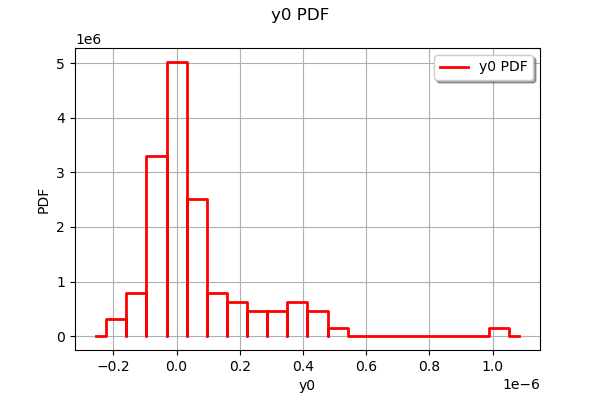

In [14]:
r = val.getResidualSample()
ot.HistogramFactory().build(r).drawPDF()

La méthode `drawValidation` permet de comparer les données observées et les prédictions du méta-modèle. 

On observe que les croix rouges sont à proximité de la première bissectrice : cela montre que le méta-modèle est plutôt de bonne qualité. Toutefois, pour les grandes déviations, les points rouges sont plus éloignées de la première bissectrice : le métamodèle est moins bon pour les grandes déviations.

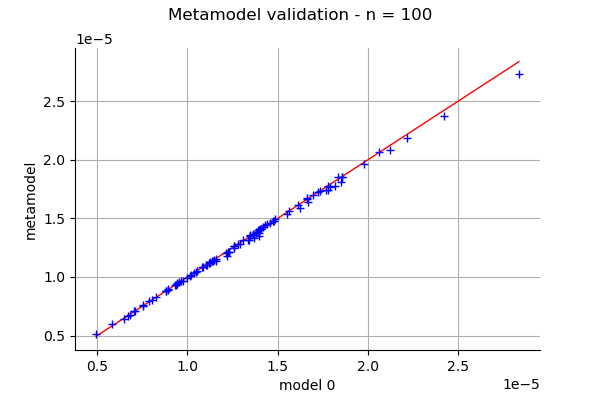

In [15]:
val.drawValidation()

### Solution de l'exercice 1 : sensibilité à la taille de l'échantillon d'apprentissage

In [16]:
sampleSize_train = 100
X_train = myDistribution.getSample(sampleSize_train)
Y_train = model(X_train)

In [17]:
dimension = myDistribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.0] * dimension, [1.0])
covarianceModel.setScale(X_train.getMax())
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.setOptimizationBounds(scaleOptimizationBounds)
algo.run()
result = algo.getResult()
krigeageMM = result.getMetaModel()

WRN - Warning! For coherency we set scale upper bounds = [3.23463e+07,74317.3,0.196294,211.909]
WRN - Starting point is not inside bounds x=[4.41792e+07,50085.6,2.59854,449.234] bounds=class=Interval name=Unnamed dimension=4 lower bound=class=Point name=Unnamed dimension=4 values=[2.80594e+07,18333.8,2.50948,346.677] upper bound=class=Point name=Unnamed dimension=4 values=[4.50901e+07,51216.3,2.59143,444.533] finite lower bound=[1,1,1,1] finite upper bound=[1,1,1,1]


In [18]:
sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = model(X_test)

In [19]:
val = ot.MetaModelValidation(X_test, Y_test, krigeageMM)
val.computePredictivityFactor()[0]

0.9999985748195588

On observe que le coefficient de prédictivité est excellent : le métamodèle avec 100 points est de très bonne qualité.

### Solution de l'exercice 2 : utilisation d'une tendance

In [20]:
sampleSize_train = 20
X_train = myDistribution.getSample(sampleSize_train)
Y_train = model(X_train)

In [21]:
dimension = myDistribution.getDimension()
basis = ot.LinearBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.0] * dimension, [1.0])
covarianceModel.setScale(X_train.getMax())
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.setOptimizationBounds(scaleOptimizationBounds)
algo.run()
result = algo.getResult()
krigeageMM = result.getMetaModel()

WRN - Warning! For coherency we set scale upper bounds = [3.5637e+07,61287.6,0.186054,249.695]
WRN - Starting point is not inside bounds x=[4.58782e+07,50033,2.5989,440.754] bounds=class=Interval name=Unnamed dimension=4 lower bound=class=Point name=Unnamed dimension=4 values=[2.80594e+07,18333.8,2.50948,346.677] upper bound=class=Point name=Unnamed dimension=4 values=[4.50901e+07,51216.3,2.59143,444.533] finite lower bound=[1,1,1,1] finite upper bound=[1,1,1,1]


In [22]:
trendCoefficients = result.getTrendCoefficients()
constantTrend = trendCoefficients[0]
constantTrend

class=Point name=Unnamed dimension=5 values=[-2.18652e-11,-1.93421e-13,1.12505e-09,-5.4228e-11,-2.82647e-08]

In [23]:
sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = model(X_test)

In [24]:
val = ot.MetaModelValidation(X_test, Y_test, krigeageMM)
val.computePredictivityFactor()[0]

0.9987670434084122

On observe que le Q2 vaut désormais 0.992 au lieu de 0.976 précédemment. Cela montre que prendre en compte une tendance linéaire a permis d'améliorer un peu la qualité du métamodèle.

### Solution de l'exercice 3 : nombre d'observations et nombre de paramètres

Comptons le nombre de paramètres estimés.

In [25]:
listOfPoints = result.getTrendCoefficients()  # One trend for each output
numberOfTrendParameters = listOfPoints[0].getDimension()
numberOfTrendParameters

5

In [26]:
estimatedCovarianceModel = result.getCovarianceModel()
indices = estimatedCovarianceModel.getActiveParameter()
numberOfCovarianceParameters = indices.getSize()
numberOfCovarianceParameters

5

In [27]:
numberOfParameters = numberOfTrendParameters + numberOfCovarianceParameters
numberOfParameters

10

In [28]:
trainingSampleSize = X_train.getSize()
trainingSampleSize

20

On calcule le ratio entre le nombre d'observations et le nombre de paramètres. 

In [29]:
learningRatio = trainingSampleSize / numberOfParameters
learningRatio

2.0

Si le nombre d'observations est très supérieur au nombre de paramètres, alors l'apprentissage est de qualité. Avec environ 2 observations par paramètres, le nombre d'observations est suffisant, mais il pourrait être plus grand pour assurer une meilleure qualité. 

### Solution de l'exercice 4 : distribution des résidus

In [30]:
val = ot.MetaModelValidation(X_test, Y_test, krigeageMM)

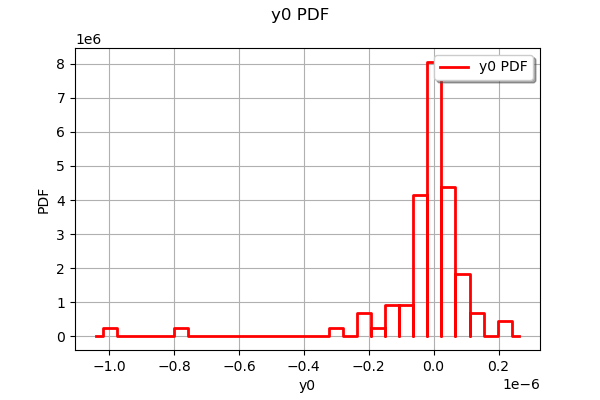

In [31]:
hist = val.getResidualDistribution(False)
hist.drawPDF()

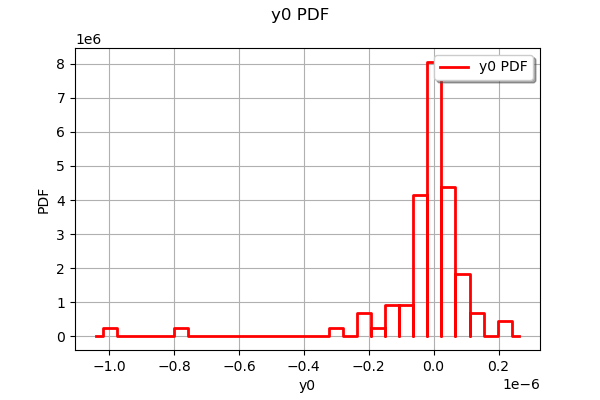

In [32]:
r = val.getResidualSample()
ot.HistogramFactory().build(r).drawPDF()

On observe que les deux graphiques sont identiques : les deux méthodes sont strictement équivalentes.

### Exercice 5 : configurer l'algorithme d'optimisation

**Questions**
* Créer le processus qui modélise l'incertitude sur $y$ (classe ConditionedGaussianProcess) sur un maillage d'une seule maille.
* A quoi peuvent servir les instructions suivantes ? Les tester.

```
# LHS design
############

K = 25 # design size
bounds = algo.getOptimizationBounds()
lbounds = bounds.getLowerBound()
ubounds = bounds.getUpperBound()
distributions = ot.DistributionCollection()
for i in range(d):
    distributions.add(ot.Uniform(lbounds[i], ubounds[i]))

def _exec(point):
    return [distributions[i].computeQuantile(point[i])[0] for i in range(d)]

transform = ot.PythonFunction(d, d, _exec)
LHS = ot.LHSExperiment(ot.ComposedDistribution([ot.Uniform(0.0, 1.0)]*d), K)
LHS.setAlwaysShuffle(True)
SA_profile = ot.GeometricProfile(10., 0.95, 20000)
LHS_optimization_algo = ot.SimulatedAnnealingLHS(LHS, SA_profile, ot.SpaceFillingC2())
LHS_optimization_algo.generate()
LHS_design = LHS_optimization_algo.getResult()
LHS_design = LHS_design.getOptimalDesign()
starting_points = transform(LHS_design)

# Change of the kriging algorithm
multiStartSolver = ot.MultiStart(solver, starting_points)
algo.setOptimizationAlgorithm(multiStartSolver)
algo.run()
```

### Solution de l'exercice 5

In [33]:
q5 = [
    E.computeQuantile(0.05)[0],
    F.computeQuantile(0.05)[0],
    L.computeQuantile(0.05)[0],
    I.computeQuantile(0.05)[0],
]
q95 = [
    E.computeQuantile(0.95)[0],
    F.computeQuantile(0.95)[0],
    L.computeQuantile(0.95)[0],
    I.computeQuantile(0.95)[0],
]
vertices = [
    q5,
    [q5[0], q5[1], q5[2], q95[3]],
    [q5[0], q5[1], q95[2], q95[3]],
    [q5[0], q95[1], q95[2], q95[3]],
    q95,
]
simplices = [[0, 1, 2, 3, 4]]
mesh = ot.Mesh(vertices, simplices)
conditionedGP = ot.ConditionedGaussianProcess(result, mesh)

Le processsu obtenu peut être utilisé pour simuler un grand nombre de trajectoires possibles, par exemple.

2e question : les lignes proposées permettent de tester la robustesse de l'optimisation de la vraisemblance lors de l'estimation des paramètres de la fonction de covariance. L'idée est de lancer l'algorithme d'optimisation, dont le déroulement dépend du point choisi pour initier l'optimisation, à partir de différents points, aussi bien répartis que possible (utilisation d'un LHS optimisé).

In [34]:
solver = algo.getOptimizationAlgorithm()

# LHS design
K = 25  # design size
bounds = algo.getOptimizationBounds()
lbounds = bounds.getLowerBound()
ubounds = bounds.getUpperBound()
distributions = ot.DistributionCollection()
for i in range(dim):
    distributions.add(ot.Uniform(lbounds[i], ubounds[i]))


def _exec(point):
    return [distributions[i].computeQuantile(point[i])[0] for i in range(dim)]


transform = ot.PythonFunction(dim, dim, _exec)
LHS = ot.LHSExperiment(ot.ComposedDistribution([ot.Uniform(0.0, 1.0)] * dim), K)
LHS.setAlwaysShuffle(True)
SA_profile = ot.GeometricProfile(10.0, 0.95, 20000)
LHS_optimization_algo = ot.SimulatedAnnealingLHS(LHS, ot.SpaceFillingC2(), SA_profile)
LHS_optimization_algo.generate()
LHS_design = LHS_optimization_algo.getResult()
LHS_design = LHS_design.getOptimalDesign()
starting_points = transform(LHS_design)

# Change of the kriging algorithm
solver.setMaximumIterationNumber(10000)
multiStartSolver = ot.MultiStart(solver, starting_points)
algo.setOptimizationAlgorithm(multiStartSolver)
algo.run()

WRN - Warning! TNC algorithm failed. The error message is Linear search failed


In [35]:
print(result.getCovarianceModel().getParameter())
new_result = algo.getResult()
print(new_result.getCovarianceModel().getParameter())

[4.50901e+07,50033,2.59143,440.754,3.60552e-05]
[2.80594e+07,51216.3,2.50948,444.533,2.48113e-05]


On observe que l'optimisation, donc le résultat du krigeage, est sensible au point initial.